 use the %autoreload magic command to automatically reload modules before executing user code. 
 %autoreload 2 reloads all modules (except those excluded by %aimport) every time before executing the Python code typed.

In [1]:
%load_ext autoreload
%autoreload 2

Add exceptions for packages to not automatic reload

In [2]:
%aimport -pandas, -numpy, -matplotlib.pyplot, -seaborn, -os, -sys -PIL.Image

Group your import statements here

In [3]:
# General libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
from PIL import Image

# Custom scripts here
# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath('../scripts')
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from scripts import my_scripts as ms

Example how to call your custom scripts

In [4]:
ms.hello_world()

'Hello, world from you library!'

Read the settings.json file and extract to variables


In [5]:
# Construct the path to the settings.json file
settings_path = os.path.join(os.path.dirname(os.getcwd()), 'settings.json')

# Read the JSON file
with open(settings_path, 'r') as file:
    settings = json.load(file)

# Accessing data from the JSON file
input_dir = ms.create_path_for_notebook(settings['data']['input-directory'])
intermediate_dir = ms.create_path_for_notebook(settings['data']['intermediate-directory'])
output_dir = ms.create_path_for_notebook(settings['data']['output-directory'])
assignment_image_path = ms.transform_path_crossplatform(os.path.join(input_dir, str(settings['data']['assignment_image'])))

# Print the paths to verify
print("input Directory:", input_dir)
print("intermediate Directory:", intermediate_dir)
print("output Directory:", output_dir)
print("assignment image:", assignment_image_path)

input Directory: ../data/input
intermediate Directory: ../data/intermediate
output Directory: ../data/output
assignment image: ../data/input/image_raw.png


Read the assignment image and display it

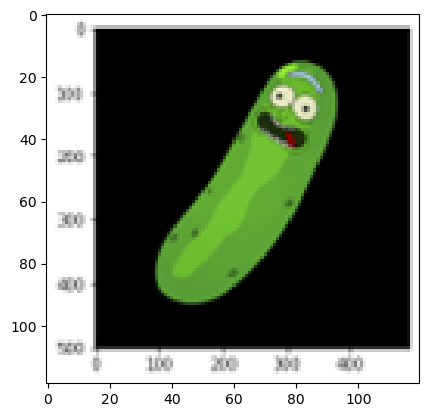

[[0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3]]


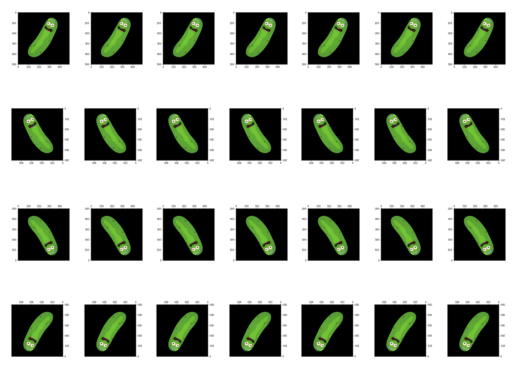

In [6]:
np_assignment_image = ms.read_image_and_convert_to_np_array(assignment_image_path)
ms.convert_np_array_and_show_image_to_plt(np_assignment_image)

# TODO -  select part of the image

# Define the matrix for flips
flip_matrix = [[i for _ in range(7)] for i in range(4)]
print(flip_matrix)

# Call the function
ms.grid_with_flips(np_assignment_image, flip_matrix)

(119, 120, 4)
(99, 100, 4)
(99, 100, 4)


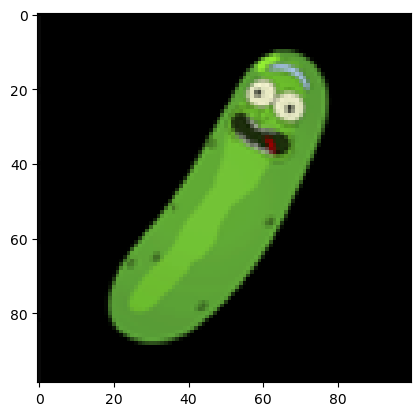

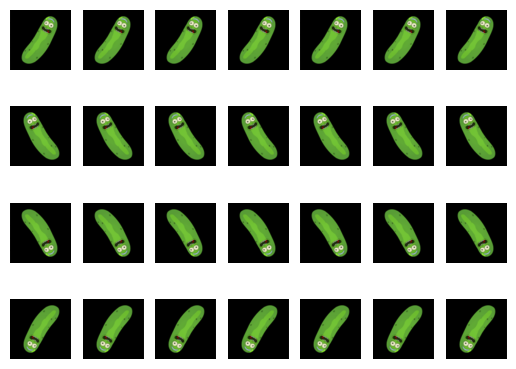

In [15]:
# Check current size of image, we need 100 x 100 for this example
print(np_assignment_image.shape) # 119 x 120 x 4 (RGB + alpha)

# Cut the image
cut_image = np_assignment_image[5:-15, 16:-4]
print(cut_image.shape)

# Ensure the image data is between 0 and 255 (as uint8 data type represents 8-bit colors)
cut_image = np.clip(cut_image * 255, 0, 255)


# Convert to uint8 data type
cut_image = cut_image.astype(np.uint8)

print(cut_image.shape)

# Save the cut image back to disk
cut_image_path = os.path.join(intermediate_dir, 'cut_image.png')
Image.fromarray(cut_image).save(cut_image_path)

# Show the cut image in the Jupyter notebook interface
ms.convert_np_array_and_show_image_to_plt(cut_image)
ms.grid_with_flips(cut_image, flip_matrix)

In [7]:
# Function to crop the non-black area of the image
def crop_non_black_area(img_array):
    # Assuming black or near-black background, we find where the image is not black
    not_black_pixels_mask = np.any(img_array[:, :, :3] != 0, axis=-1)

    # Find the bounding box of those pixels
    non_black_area_coords = np.argwhere(not_black_pixels_mask)
    y_min, x_min = non_black_area_coords.min(axis=0)
    y_max, x_max = non_black_area_coords.max(axis=0)

    # Crop the image using the bounding box
    cropped_img = img_array[y_min:y_max+1, x_min:x_max+1]
    return cropped_img

# Crop the figure from the image
cropped_figure = crop_non_black_area(image_array)

# Display the cropped figure
plt.imshow(cropped_figure)
plt.title(f"Cropped Figure - Shape: {cropped_figure.shape}")
plt.axis('off')
plt.show()


In [ ]:
# Define the pattern dimensions observed in "image_manip1.png" (5x5 figures)
pattern_rows = 5
pattern_columns = 5
spacing = 10  # Assume a spacing of 10 pixels between each figure

# Calculate the size of the new image
new_image_height = pattern_rows * cropped_figure.shape[0] + (pattern_rows - 1) * spacing
new_image_width = pattern_columns * cropped_figure.shape[1] + (pattern_columns - 1) * spacing

# Create a new blank image with a black background
patterned_image = np.zeros((new_image_height, new_image_width, 4), dtype=np.uint8)

# Loop through each position in the pattern and place the cropped figure
for row in range(pattern_rows):
    for col in range(pattern_columns):
        top_left_y = row * (cropped_figure.shape[0] + spacing)
        top_left_x = col * (cropped_figure.shape[1] + spacing)
        # Place the cropped figure onto the patterned image
        patterned_image[top_left_y:top_left_y + cropped_figure.shape[0],
        top_left_x:top_left_x + cropped_figure.shape[1]] = cropped_figure

# Save the new patterned image to a temporary location
patterned_image_path = '/mnt/data/patterned_image.png'
Image.fromarray(patterned_image).save(patterned_image_path)

# Display the patterned image
plt.imshow(patterned_image)
plt.title("Patterned Image")
plt.axis('off')
plt.show()

patterned_image_path


# Function to center an image within a given size with a transparent background
def center_image(img_array, target_height, target_width):
    # Create a transparent image of the desired size
    centered_img = np.zeros((target_height, target_width, 4), dtype=np.uint8)

    # Calculate the position to place the cropped image to be centered
    y_offset = (target_height - img_array.shape[0]) // 2
    x_offset = (target_width - img_array.shape[1]) // 2

    # Place the cropped image onto the centered image
    centered_img[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array
    return centered_img

# Center each figure within a 100x100 pixel matrix
centered_figure = center_image(cropped_figure, 100, 100)

# Create a new pattern image with centered figures
patterned_centered_image = np.zeros((new_image_height, new_image_width, 4), dtype=np.uint8)

# Repeat the placement for the pattern
for row in range(pattern_rows):
    for col in range(pattern_columns):
        top_left_y = row * (100 + spacing)
        top_left_x = col * (100 + spacing)
        patterned_centered_image[top_left_y:top_left_y + 100,
                                 top_left_x:top_left_x + 100] = centered_figure

# Save the new patterned centered image to a temporary location
patterned_centered_image_path = '/mnt/data/patterned_centered_image.png'
Image.fromarray(patterned_centered_image).save(patterned_centered_image_path)

# Display the patterned centered image
plt.imshow(patterned_centered_image)
plt.title("Patterned Centered Image")
plt.axis('off')
plt.show()

patterned_centered_image_path


In [ ]:
# Recalculate the new image size to fit the 100x100 centered figures with spacing
new_image_height = pattern_rows * 100 + (pattern_rows - 1) * spacing
new_image_width = pattern_columns * 100 + (pattern_columns - 1) * spacing

# Create a new blank image with a transparent background to accommodate the new dimensions
patterned_centered_image = np.zeros((new_image_height, new_image_width, 4), dtype=np.uint8)

# Place the centered figure into the new image in a pattern
for row in range(pattern_rows):
    for col in range(pattern_columns):
        # Calculate the top-left position for each figure in the pattern
        top_left_y = row * (100 + spacing)
        top_left_x = col * (100 + spacing)
        # Place the centered figure onto the patterned image
        patterned_centered_image[top_left_y:top_left_y + 100, top_left_x:top_left_x + 100] = centered_figure

# Save the new patterned centered image to a temporary location
patterned_centered_image_path = '/mnt/data/patterned_centered_image.png'
Image.fromarray(patterned_centered_image).save(patterned_centered_image_path)

# Display the patterned centered image
plt.imshow(patterned_centered_image)
plt.title("Patterned Centered Image")
plt.axis('off')
plt.show()

patterned_centered_image_path


In [ ]:
# Adjusting the pattern to have no spacing between images
# This means the new image height and width will be exactly 5 times the height and width of the centered figure

# Calculate the size of the new patterned image without any spacing
new_image_height_no_spacing = pattern_rows * 100  # 5 figures each 100px tall
new_image_width_no_spacing = pattern_columns * 100  # 5 figures each 100px wide

# Create a new blank image with a transparent background to accommodate the new dimensions
patterned_centered_image_no_spacing = np.zeros((new_image_height_no_spacing, new_image_width_no_spacing, 4), dtype=np.uint8)

# Place the centered figure into the new image in a pattern without any spacing
for row in range(pattern_rows):
    for col in range(pattern_columns):
        # Calculate the top-left position for each figure in the pattern
        top_left_y = row * 100
        top_left_x = col * 100
        # Place the centered figure onto the patterned image
        patterned_centered_image_no_spacing[top_left_y:top_left_y + 100, top_left_x:top_left_x + 100] = centered_figure

# Save the new patterned centered image without spacing to a temporary location
patterned_centered_image_no_spacing_path = '/mnt/data/patterned_centered_image_no_spacing.png'
Image.fromarray(patterned_centered_image_no_spacing).save(patterned_centered_image_no_spacing_path)

# Display the patterned centered image without spacing
plt.imshow(patterned_centered_image_no_spacing)
plt.title("Patterned Centered Image - No Spacing")
plt.axis('off')
plt.show()

patterned_centered_image_no_spacing_path


In [ ]:
# To change the transparent pixels to black, we need to set the alpha channel to 255 (fully opaque)
# and set the color channels to 0 where the alpha channel is currently 0 (fully transparent)

# Copy the image to avoid altering the original array
patterned_image_black_background = patterned_centered_image_no_spacing.copy()

# Where the alpha channel is 0, set the color channels to 0 (black) and alpha channel to 255 (opaque)
transparent_mask = patterned_image_black_background[:, :, 3] == 0
patterned_image_black_background[transparent_mask] = [0, 0, 0, 255]

# Save the new image
patterned_image_black_background_path = '/mnt/data/patterned_image_black_background.png'
Image.fromarray(patterned_image_black_background).save(patterned_image_black_background_path)

# Display the image
plt.imshow(patterned_image_black_background)
plt.title("Patterned Image with Black Background")
plt.axis('off')
plt.show()

patterned_image_black_background_path


In [ ]:
import matplotlib.ticker as ticker

# Create a figure and axis to plot the image
fig, ax = plt.subplots(figsize=(8, 8))

# Display the image with black background
ax.imshow(patterned_image_black_background)

# Set the x and y axis ticks to go from 0 to 500, in steps of 100
ax.set_xticks(np.arange(0, new_image_width_no_spacing, 100))
ax.set_yticks(np.arange(0, new_image_height_no_spacing, 100))

# Set the labels for the ticks
ax.set_xticklabels(np.arange(0, new_image_width_no_spacing, 100))
ax.set_yticklabels(np.arange(0, new_image_height_no_spacing, 100))

# Set the grid with black lines
ax.grid(color='black', linestyle='-', linewidth=2)

# Invert the y-axis to have 0 start at the top
ax.invert_yaxis()

# Set the tick labels color to black
ax.tick_params(colors='black', which='both')

# Save the figure with the axis
patterned_image_with_axes_path = '/mnt/data/patterned_image_with_axes.png'
plt.savefig(patterned_image_with_axes_path, bbox_inches='tight')

plt.show()

patterned_image_with_axes_path


In [ ]:
# Create a figure and axis to plot the image with inverted y-axis labels
fig, ax = plt.subplots(figsize=(8, 8))

# Display the image with black background
ax.imshow(patterned_image_black_background)

# Set the x and y axis ticks to go from 0 to 500, in steps of 100
ax.set_xticks(np.arange(0, new_image_width_no_spacing, 100))
ax.set_yticks(np.arange(0, new_image_height_no_spacing, 100))

# Set the labels for the ticks
ax.set_xticklabels(np.arange(0, new_image_width_no_spacing, 100))
# Invert the y-axis labels so they start from 0 at the top
ax.set_yticklabels(np.arange(new_image_height_no_spacing-100, -100, -100))

# Set the grid with black lines
ax.grid(color='black', linestyle='-', linewidth=2)

# Invert the y-axis to have 0 start at the top
ax.invert_yaxis()

# Set the tick labels color to black
ax.tick_params(colors='black', which='both')

# Save the figure with the axis and inverted y-axis labels
patterned_image_with_inverted_y_path = '/mnt/data/patterned_image_with_inverted_y.png'
plt.savefig(patterned_image_with_inverted_y_path, bbox_inches='tight')

plt.show()

patterned_image_with_inverted_y_path


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.ticker as ticker

# Function to crop the non-black area of the image
def crop_non_black_area(img_array):
    not_black_pixels_mask = np.any(img_array[:, :, :3] != 0, axis=-1)
    non_black_area_coords = np.argwhere(not_black_pixels_mask)
    y_min, x_min = non_black_area_coords.min(axis=0)
    y_max, x_max = non_black_area_coords.max(axis=0)
    return img_array[y_min:y_max+1, x_min:x_max+1]

# Function to center an image within a given size with a transparent background
def center_image(img_array, target_height, target_width):
    centered_img = np.zeros((target_height, target_width, 4), dtype=np.uint8)
    y_offset = (target_height - img_array.shape[0]) // 2
    x_offset = (target_width - img_array.shape[1]) // 2
    centered_img[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array
    return centered_img

# Function to create a patterned image with centered figures
def create_patterned_image(cropped_figure, rows, cols):
    new_image_height = rows * 100
    new_image_width = cols * 100
    patterned_image = np.zeros((new_image_height, new_image_width, 4), dtype=np.uint8)
    for row in range(rows):
        for col in range(cols):
            top_left_y = row * 100
            top_left_x = col * 100
            patterned_image[top_left_y:top_left_y + 100, top_left_x:top_left_x + 100] = cropped_figure
    return patterned_image

# Function to change transparent pixels to black
def add_black_background(img_array):
    img_array[img_array[:, :, 3] == 0] = [0, 0, 0, 255]
    return img_array

# Function to add X and Y axes to the image
def add_axes_to_image(img_array, rows, cols):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_array)
    ax.set_xticks(np.arange(0, cols * 100, 100))
    ax.set_yticks(np.arange(0, rows * 100, 100))
    ax.set_xticklabels(np.arange(0, cols * 100, 100))
    y_labels = np.arange(0, rows * 100, 100)
    ax.set_yticklabels(y_labels[::-1])
    ax.grid(color='black', linestyle='-', linewidth=2)
    ax.invert_yaxis()
    ax.tick_params(colors='black', which='both')
    plt.savefig('/mnt/data/patterned_image_with_axes.png', bbox_inches='tight')
    plt.close(fig)
    return '/mnt/data/patterned_image_with_axes.png'

def resize_image(img_array, factor):
    # Use PIL to resize the image
    img = Image.fromarray(img_array)
    img = img.resize((img_array.shape[1] * factor, img_array.shape[0] * factor), Image.NEAREST)
    return np.array(img)

def flip_rotate_image(img_array, flip_horizontal=False, flip_vertical=False, rotate_angle=0):
    # Use PIL for flipping and rotating
    img = Image.fromarray(img_array)
    if flip_horizontal:
        img = ImageOps.mirror(img)
    if flip_vertical:
        img = ImageOps.flip(img)
    img = img.rotate(rotate_angle, expand=True)
    return np.array(img)

def change_image_color(img_array, color):
    # Copy the image to avoid altering the original array
    colored_img = img_array.copy()
    # Create a mask where the image is not transparent
    mask = colored_img[:, :, 3] != 0
    # Change the color of the image where it is not transparent
    if color.lower() == 'red':
        colored_img[mask] = [255, 0, 0, 255]
    elif color.lower() == 'blue':
        colored_img[mask] = [0, 0, 255, 255]
    # Add other colors as needed
    # elif color.lower() == 'green':
    #     colored_img[mask] = [0, 255, 0, 255]
    return colored_img

# Main function to process the image
def process_image(image_path, rows, cols):
    image_raw = Image.open(image_path)
    image_array = np.array(image_raw)
    cropped_figure = crop_non_black_area(image_array)
    centered_figure = center_image(cropped_figure, 100, 100)
    patterned_image = create_patterned_image(centered_figure, rows, cols)
    patterned_image_with_background = add_black_background(patterned_image)
    final_image_path = add_axes_to_image(patterned_image_with_background, rows, cols)
    return final_image_path


# Example usage:
image_path = '/mnt/data/image_raw.png'
final_image_path = process_image(image_path, 5, 5)

# Load the final image to apply new operations
final_image_array = np.array(Image.open(final_image_path))

# Resize the image by a factor of 2
resized_image = resize_image(final_image_array, 2)

# Flip and rotate the image (90 degrees for example)
flipped_rotated_image = flip_rotate_image(resized_image, flip_horizontal=True, rotate_angle=90)

# Change the color of the image to red
red_image = change_image_color(flipped_rotated_image, 'red')

# Save the red image
red_image_path = '/mnt/data/red_patterned_image.png'
Image.fromarray(red_image).save(red_image_path)

print(f"Red image saved to: {red_image_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to flip the image based on the matrix values
def grid_with_flips(image, matrix):
    flipped_images = []
    for row in matrix:
        image_row = []
        for flip_type in row:
            if flip_type == 0:
                flipped_image = image.copy()
            elif flip_type == 1:
                flipped_image = np.fliplr(image)
            elif flip_type == 2:
                flipped_image = np.flipud(image)
            elif flip_type == 3:
                flipped_image = np.flipud(np.fliplr(image))
            image_row.append(flipped_image)
        flipped_images.append(np.concatenate(image_row, axis=1))
    return np.concatenate(flipped_images, axis=0)

# Function to change the color of non-transparent pixels
def change_color(image, color_value):
    colored_image = image.copy()
    alpha = colored_image[:, :, 3] != 0
    colored_image[:, :, :3][alpha] = color_value
    return colored_image

# Function to create a pattern with colorful borders
def create_colorful_big_one(colors):
    # Assuming colors is a list of 12 RGB values (4 sides with 3 colors each)
    side_length = image.shape[0]  # The length of a side of the image
    big_one = np.zeros((3 * side_length, 3 * side_length, 4), dtype=np.uint8)
    for i, color in enumerate(colors):
        color_value = np.array(color, dtype=np.uint8)
        if i < 3:  # Top side
            big_one[:side_length, i * side_length:(i + 1) * side_length, :] = change_color(image, color_value)
        elif i < 6:  # Right side
            big_one[i % 3 * side_length:(i % 3 + 1) * side_length, 2 * side_length:, :] = change_color(image, color_value)
        elif i < 9:  # Bottom side
            big_one[2 * side_length:, (8 - i) * side_length:(7 - i) * side_length, :] = change_color(image, color_value)
        else:  # Left side
            big_one[(11 - i) * side_length:(10 - i) * side_length, :side_length, :] = change_color(image, color_value)
    # Place the original image in the center
    big_one[side_length:2 * side_length, side_length:2 * side_length, :] = image
    return big_one

# Function to combine the grid and color functions
def combined_manipulation(image, flip_matrix, colors):
    # Create the grid with flips first
    flipped_grid = grid_with_flips(image, flip_matrix)
    # Apply the colorful border pattern
    colorful_pattern = create_colorful_big_one(colors)
    # Overlay the flipped grid on the colorful pattern
    y_offset = (colorful_pattern.shape[0] - flipped_grid.shape[0]) // 2
    x_offset = (colorful_pattern.shape[1] - flipped_grid.shape[1]) // 2
    overlay_image = colorful_pattern.copy()
    overlay_image[y_offset:y_offset+flipped_grid.shape[0], x_offset:x_offset+flipped_grid.shape[1], :] = flipped_grid
    return overlay_image

# Example usage of the functions to replace Step 4 with a single function call
# Load your image as a numpy array
image = np.array(Image.open('path/to/your/image.png'))

# Perform the manipulations and display the results
flip_matrix = [[1 for _ in range(7)] for _ in range(3)]
colors = [
    [0, 0, 255], [0, 0, 255], [0, 0, 255],  # Blue
    [255, 0, 0], [255, 0, 0],                # Red
    [0, 255, 0], [0, 255, 0], [0, 255, 0],  # Green
    [255, 0, 0], [255, 0, 0]                 # Red
]

manipulated_image = combined_manipulation(image, flip_matrix, colors)

plt.imshow(manipulated_image)
plt.axis('off')
plt.show()
